In [93]:
import time
notebook_start = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, plot_roc_curve, 
                             accuracy_score, recall_score, precision_score, f1_score)

In [2]:
pd.set_option('display.max_colwidth', None)
# download a dataset with a description of each column
feat_def = pd.read_excel('https://resources.lendingclub.com/LCDataDictionary.xlsx')

accepted_df = pd.read_csv('data/accepted_16_to_18.csv')
print(accepted_df.info())
accepted_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482754 entries, 0 to 482753
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   term              482754 non-null  object 
 1   int_rate          482754 non-null  float64
 2   grade             482754 non-null  object 
 3   dti               482754 non-null  float64
 4   loan_status       482754 non-null  int64  
 5   emp_length        482754 non-null  object 
 6   loan_amnt         482754 non-null  float64
 7   annual_inc        482754 non-null  float64
 8   application_type  482754 non-null  object 
 9   home_ownership    482754 non-null  object 
 10  date              482754 non-null  object 
 11  zip_code          482754 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 44.2+ MB
None


,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
0,36 months,11.22,B,3.10,0,7 years,5000.0,65000.0,Individual,MORTGAGE,2016-01-01,201xx
1,36 months,9.17,B,20.30,0,10+ years,35000.0,82400.0,Individual,MORTGAGE,2016-01-01,146xx
2,36 months,5.32,A,7.43,0,9 years,20000.0,200000.0,Individual,OWN,2016-01-01,208xx
3,36 months,10.78,B,2.75,0,6 years,6000.0,85000.0,Individual,RENT,2016-01-01,908xx
4,36 months,12.88,C,8.07,1,< 1 year,3725.0,16800.0,Individual,RENT,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482749,36 months,14.47,C,23.76,0,10+ years,7450.0,76000.0,Individual,MORTGAGE,2018-12-01,483xx
482750,36 months,12.98,B,26.50,0,10+ years,9600.0,75000.0,Individual,RENT,2018-12-01,917xx
482751,36 months,7.02,A,16.38,0,< 1 year,20000.0,97000.0,Individual,RENT,2018-12-01,801xx
482752,36 months,15.02,C,11.64,0,< 1 year,10000.0,66000.0,Individual,OWN,2018-12-01,452xx


## Pre-processing

As I mentioned in the cleaning and eda notebook, I am going to focus on predicting the loans with high interest. But first I'll try to predict on all the loans.

I will scale the numerical data, and use a label encoder to put the categorical features in numeric form so the model can handle them. I will scale after the train test split to avoid any leakage.

In [3]:
df = accepted_df.copy()
# instantiate a label encoder and transform the categorical features
le = LabelEncoder()
df['application_type'] = le.fit_transform(df['application_type'])
df['term'] = le.fit_transform(df['term'])
df['grade'] = le.fit_transform(df['grade'])
df['home_ownership'] = le.fit_transform(df['home_ownership'])
df['emp_length'] = le.fit_transform(df['emp_length'])
df

,term,int_rate,grade,dti,loan_status,emp_length,loan_amnt,annual_inc,application_type,home_ownership,date,zip_code
0,0,11.22,1,3.10,0,7,5000.0,65000.0,0,1,2016-01-01,201xx
1,0,9.17,1,20.30,0,1,35000.0,82400.0,0,1,2016-01-01,146xx
2,0,5.32,0,7.43,0,9,20000.0,200000.0,0,3,2016-01-01,208xx
3,0,10.78,1,2.75,0,6,6000.0,85000.0,0,4,2016-01-01,908xx
4,0,12.88,2,8.07,1,10,3725.0,16800.0,0,4,2016-01-01,294xx
...,...,...,...,...,...,...,...,...,...,...,...,...
482749,0,14.47,2,23.76,0,1,7450.0,76000.0,0,1,2018-12-01,483xx
482750,0,12.98,1,26.50,0,1,9600.0,75000.0,0,4,2018-12-01,917xx
482751,0,7.02,0,16.38,0,10,20000.0,97000.0,0,4,2018-12-01,801xx
482752,0,15.02,2,11.64,0,10,10000.0,66000.0,0,3,2018-12-01,452xx


In [4]:
# split the data into a training set and testing set.
# I won't be using the date or zip_codes for the training.
X = df.drop(['loan_status', 'date', 'zip_code'],axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [5]:
# instantiate scaler
sc = StandardScaler()

# seperate the numerical and categorical columns for training and testing data so that I can scale the numerical
# and then concatenate them.
# reset the index for smoothe concatenation
num_train = X_train.select_dtypes(include='float64').reset_index(drop=True)
num_test = X_test.select_dtypes(include='float64').reset_index(drop=True)
cat_train = X_train.select_dtypes(include='int32').reset_index(drop=True)
cat_test = X_test.select_dtypes(include='int32').reset_index(drop=True)

# fit and transform the scaler on training and testing data
sc_num_train = sc.fit_transform(num_train)
sc_num_test = sc.transform(num_test)
# put the scaled data back into a dataframe
sc_train_df = pd.DataFrame(sc_num_train, columns=num_train.columns)
sc_test_df = pd.DataFrame(sc_num_test, columns=num_test.columns)

# concatenate back together
X_train_ready = pd.concat([sc_train_df, cat_train], axis=1)
X_test_ready = pd.concat([sc_test_df, cat_test], axis=1)

Here's a baseline model to compare the rest of our models to.

0.6577871682271385

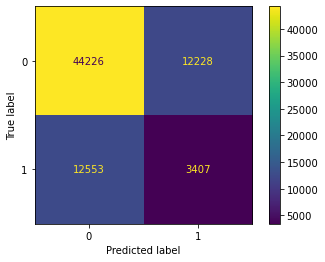

In [17]:
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train_ready, y_train)
plot_confusion_matrix(dummy, X_test_ready, y_test)
dummy.score(X_test_ready, y_test)

In [51]:
# def logreg(X_train, X_test, y_train, y_test, cv=5):
    
#     # Set GridSearchCV hyperparameters to compare & select
#     weights = [-10, 1, 10, 100]
#     grid = {
#     'C': [0.01, 0.1, 1, 10],
#     'class_weight': [{0:100, 1:1}, {0:10, 1:1}, {0:1, 1:1}, {0:1, 1:10}, {0:1, 1:100}]
# #     'class_weight':[{0:x, 1:1.0-x} for x in weights]
#     }
    
#     # Instantiate & fit LogReg model for GridSearch
#     grid_logreg = LogisticRegression(random_state=42)
#     # Instantiate & fit GridSearchCV with accuracy scoring
#     gs = GridSearchCV(estimator=grid_logreg, param_grid=grid, cv=cv, scoring='accuracy')
#     gs.fit(X_train, y_train)
#     print(gs.best_params_)
#     # Create prediction variable using test data
#     y_pred = gs.predict(X_test)
#     # Run cross-validate score with cv folds from function parameter
#     cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
#     print(f'Mean Cross-Val Score: {round(cv_results.mean(), 4)*100}')
#     # Run and print accuracy, recall, precision and f1 scores
#     train_score = gs.score(X_train, y_train)
#     print(f'Train Mean Accuracy: {round(train_score, 4)*100}')
#     test_score = gs.score(X_test, y_test)
#     print(f'Accuracy Score: {round(test_score, 4)*100}')
#     rec_score = recall_score(y_test, y_pred)
#     print(f'Recall Score: {round(rec_score, 4)*100}')
#     prec_score = precision_score(y_test, y_pred)
#     print(f'Precision Score: {round(prec_score, 4)*100}')
#     f1 = f1_score(y_test, y_pred)
#     print(f'F1 Score: {round(f1, 4)*100}')
#     # Plot an ROC curve 
#     fig, ax = plt.subplots()
#     plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
#     plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
#     # Plot Confusion Matrix
#     plot_confusion_matrix(gs, X_test, y_test)

Accuracy of Regularized Logistic Regression is: 78.24
Recall of Regularized Logistic Regression is: 9.91


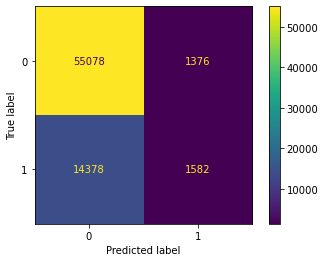

In [60]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42)
lr.fit(X_train_ready,y_train)
pred_lr = lr.predict(X_test_ready)
accuracy_lr= accuracy_score(y_test, pred_lr)*100
recall_lr = recall_score(y_test, pred_lr)*100
print('Accuracy of Regularized Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Regularized Logistic Regression is: {:.2f}'.format(recall_lr))
confusion_matrix(lr, X_test_ready, y_test);

Being able to predict almost 80 percent of the time, should be enough to make you money with this type of investment. However if we're trying to find an edge to get soem very good value, our model needs to be more sensitive to the defaulted loans. Even if our model tells us that a lot of loans will default when in reality only a few will, if narrow down our investments to the loans the model does not think will default, we get a much better return. So far our model does a very poor job identifying the charged off loans. This is largely due to the great imbalance in the classes, which makes it very hard for the model to learn what a defaulted loan would look like.

To help with this, I can alter the weights of each class to put more weight on the minority class. Or I can change the threshhold for predicting a "1" to make it more sensitive. I can also use SMOTE to correct the imbalance and see if these techniques will improve the score. This will probably come at the cost of overall accuracy, but we're happy to make that trade since this will get us better returns for the investment.

I will also try to tune the hyperparameters for the model using a grid search, as well as try some other algorithms that may perform better.

# True Negative rate!

In [96]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42)
lr.fit(X_train_ready,y_train)
pred_lr = (lr.predict_proba(X_test_ready)[:,1] >= 0.2).astype(bool)
accuracy_lr= accuracy_score(y_test, pred_lr)*100
recall_lr = recall_score(y_test, pred_lr)*100
print('Accuracy of Regularized Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Regularized Logistic Regression is: {:.2f}'.format(recall_lr))
print(confusion_matrix(y_test, pred_lr))

Accuracy of Regularized Logistic Regression is: 62.48
Recall of Regularized Logistic Regression is: 67.54
[[34467 21987]
 [ 5180 10780]]


In [66]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train_ready, y_train)
y_train_sm.value_counts()

1    0.5
0    0.5
Name: loan_status, dtype: float64

In [67]:
y_train_sm.value_counts()

1    321106
0    321106
Name: loan_status, dtype: int64

Now that I have balanced classes, the model may perform better.

Accuracy of Regularized Logistic Regression is: 62.84
Recall of Regularized Logistic Regression is: 67.27


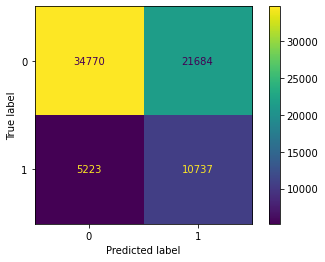

In [76]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42, class_weight={0:1, 1:4})
lr.fit(X_train_ready,y_train)
pred_lr = lr.predict(X_test_ready)
accuracy_lr= accuracy_score(y_test, pred_lr)*100
recall_lr = recall_score(y_test, pred_lr)*100
print('Accuracy of Regularized Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Regularized Logistic Regression is: {:.2f}'.format(recall_lr))
plot_confusion_matrix(lr, X_test_ready, y_test);

Accuracy of Regularized Logistic Regression is: 65.94
Recall of Regularized Logistic Regression is: 61.68


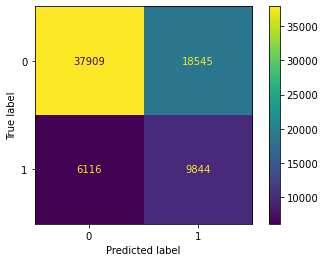

In [77]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42)
lr.fit(X_train_sm, y_train_sm)
pred_lr = lr.predict(X_test_ready)
accuracy_lr= accuracy_score(y_test, pred_lr)*100
recall_lr = recall_score(y_test, pred_lr)*100
print('Accuracy of Regularized Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Regularized Logistic Regression is: {:.2f}'.format(recall_lr))
plot_confusion_matrix(lr, X_test_ready, y_test);

Accuracy of Regularized Random Forest is: 73.65
Recall of Regularized Random Forest is: 31.28


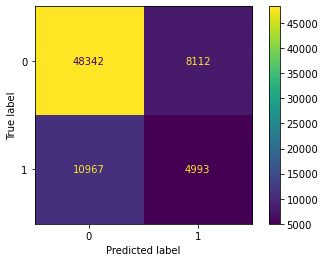

In [78]:
# Do the same with random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sm, y_train_sm)
pred_rf = rf.predict(X_test_ready)
accuracy_rf= accuracy_score(y_test, pred_rf)*100
recall_rf = recall_score(y_test, pred_rf)*100
print('Accuracy of Random Forest is: {:.2f}'.format(accuracy_rf))
print('Recall of Random Forest is: {:.2f}'.format(recall_rf))
plot_confusion_matrix(rf, X_test_ready, y_test);

Accuracy of Logistic Regression is: 65.75
Recall of Logistic Regression is: 62.12


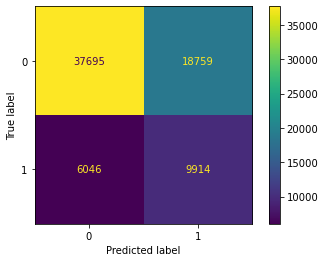

In [79]:
# Instantiate a logistic regression then fit it on X_train and get the scoring metrics witha confusion matrix
lr=LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train_ready,y_train)
pred_lr = lr.predict(X_test_ready)
accuracy_lr= accuracy_score(y_test, pred_lr)*100
recall_lr = recall_score(y_test, pred_lr)*100
print('Accuracy of Logistic Regression is: {:.2f}'.format(accuracy_lr))
print('Recall of Logistic Regression is: {:.2f}'.format(recall_lr))
plot_confusion_matrix(lr, X_test_ready, y_test);

As we mentioned earlier I will try to predict the loans that have higher int_rates.

In [86]:
accepted_df[accepted_df.int_rate > accepted_df.int_rate.median()].grade.value_counts(normalize=True)

C    0.529678
D    0.286912
E    0.122274
F    0.043972
G    0.016633
B    0.000531
Name: grade, dtype: float64

In [84]:
accepted_df.grade.value_counts(normalize=True)

C    0.301775
B    0.291689
A    0.171659
D    0.143452
E    0.061120
F    0.021984
G    0.008321
Name: grade, dtype: float64

In [ ]:
notebook_end = time.time()
print(f'This notebook takes {round(notebook_end - notebook_start, 0)} seconds to run')